In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re
from google.colab import files

In [4]:
# Allow file upload
uploaded = files.upload()

Saving Scatter_plot.xlsx to Scatter_plot.xlsx


In [5]:
# STEP 3: Load data
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name, sheet_name='Sheet1')

In [6]:
df


,Gene Name,HNOX_1,HNOX_2,HNOX_3,WT_1,WT_2,WT_3
0,Pden_0444,0.0,0.0,0.0,15861000.0,15839000.0,15009000.0
1,ppk,0.0,0.0,0.0,2335300.0,2519400.0,2585500.0
2,Pden_4022,0.0,0.0,0.0,4163000.0,4203200.0,3781000.0
3,Pden_4104,0.0,0.0,0.0,4776700.0,5177700.0,4477700.0
4,Pden_0682,0.0,0.0,0.0,2232800.0,1855500.0,2098100.0
...,...,...,...,...,...,...,...
1753,Pden_5055,0.0,0.0,0.0,0.0,0.0,0.0
1754,Pden_5103,0.0,0.0,0.0,0.0,0.0,0.0
1755,Pden_5116,0.0,0.0,0.0,0.0,0.0,0.0
1756,Pden_5123,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Calculate mean for WT and DM replicates
df['WT_Mean'] = df[['WT_1', 'WT_2', 'WT_3']].mean(axis=1)
df['HNOX_Mean'] = df[['HNOX_1', 'HNOX_2', 'HNOX_3']].mean(axis=1)

In [10]:
# Calculate log2 fold-change
df['Log2_FC'] = np.log2(df['HNOX_Mean'] / df['WT_Mean'].replace(0, np.nan))

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['WT_1', 'WT_2', 'WT_3']].values,
    df[['HNOX_1', 'HNOX_2', 'HNOX_3']].values,
    axis=1, nan_policy='omit'
)

In [12]:
# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])


In [13]:
# Filter top 10 significant genes from both sides
top_genes = pd.concat([
    df.nsmallest(10, 'P_Value').nsmallest(10, 'Log2_FC'),  # Top 10 down-regulated
    df.nsmallest(10, 'P_Value').nlargest(10, 'Log2_FC')   # Top 10 up-regulated
])

/usr/local/lib/python3.12/dist-packages/matplotlib/transforms.py:351: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]


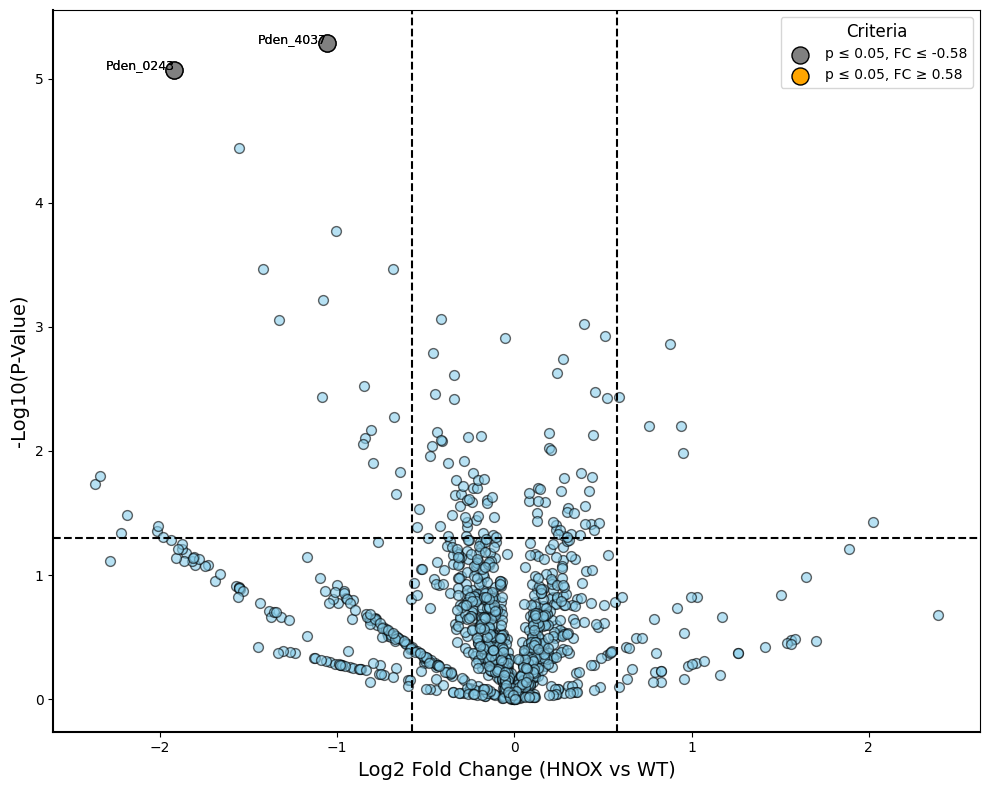

In [15]:
# Separate significant genes for coloring
left_candidates = top_genes[top_genes['Log2_FC'] < -0.58]
right_candidates = top_genes[top_genes['Log2_FC'] >= 0.58]

# Create the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB')
# Highlight significant genes
plt.scatter(left_candidates['Log2_FC'], left_candidates['MinusLog10_P'], color='grey', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≤ -0.58')
plt.scatter(right_candidates['Log2_FC'], right_candidates['MinusLog10_P'], color='orange', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≥ 0.58')

# Add gene labels
for _, row in top_genes.iterrows():
    plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Gene Name'], fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0.58, color='black', linestyle='--')
plt.axvline(-0.58, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (HNOX vs WT)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
# Save the plot as PNG (600 DPI) and PDF
png_path = 'volcano_plot1.png'
pdf_path = 'volcano_plot1.pdf'
plt.savefig(png_path, dpi=600, format='png')
plt.savefig(pdf_path, format='pdf')
plt.tight_layout()
# Show the plot
plt.show()
# Download the files
#files.download(png_path)
#files.download(pdf_path)
